In [1]:
import sklearn

In [2]:
from sklearn.datasets import load_iris

In [3]:
X, y = load_iris(return_X_y=True)

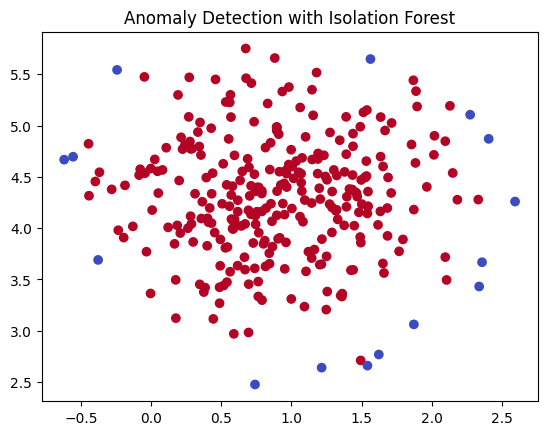

In [6]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

X, _ = make_blobs(n_samples=300, centers=1, cluster_std=0.60, random_state=0)

model = IsolationForest(contamination=0.05)
model.fit(X)
y_pred = model.predict(X)

# Visualization
plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='coolwarm')
plt.title("Anomaly Detection with Isolation Forest")
plt.show()


In [12]:
import pandas as pd
import random
from datetime import datetime, timedelta

def generate_telecom_data(
    start_date="2024-01-01",
    end_date="2024-01-31",
    countries_ops=None,
    seed=42
):
    if countries_ops is None:
        countries_ops = {
            "Canada": ["Bell", "Rogers", "Telus"],
            "France": ["Orange", "SFR", "Bouygues"],
            "Tunisia": ["Ooredoo", "Orange TN", "Tunisie Telecom"]
        }

    random.seed(seed)
    date_range = pd.date_range(start=start_date, end=end_date)

    data = []
    for date in date_range:
        for country, operators in countries_ops.items():
            for operator in operators:
                subscribers = random.randint(1000, 90000)
                data.append({
                    "date": date.date(),
                    "country": country,
                    "operator": operator,
                    "number_of_subscribers": subscribers
                })

    return pd.DataFrame(data)

# Example usage
df = generate_telecom_data(start_date="2025-06-01", end_date="2025-06-19")
print(df.head(20))

# Optional: save to CSV or JSON
# df.to_csv("telecom_data.csv", index=False)
# df.to_json("telecom_data.json", orient="records", lines=True)


          date  country         operator  number_of_subscribers
0   2025-06-01   Canada             Bell                  84810
1   2025-06-01   Canada           Rogers                  15592
2   2025-06-01   Canada            Telus                   4278
3   2025-06-01   France           Orange                  37048
4   2025-06-01   France              SFR                  33098
5   2025-06-01   France         Bouygues                  30256
6   2025-06-01  Tunisia          Ooredoo                  19289
7   2025-06-01  Tunisia        Orange TN                  14434
8   2025-06-01  Tunisia  Tunisie Telecom                  89696
9   2025-06-02   Canada             Bell                  72482
10  2025-06-02   Canada           Rogers                  12395
11  2025-06-02   Canada            Telus                  78397
12  2025-06-02   France           Orange                  56302
13  2025-06-02   France              SFR                   5165
14  2025-06-02   France         Bouygues

In [14]:
from sklearn.ensemble import IsolationForest

# For each country, detect anomalies independently
def detect_anomalies_countrywise(data):
    all_results = []

    for country in data['country'].unique():
        subset = data[data['country'] == country].copy()

        model = IsolationForest(contamination=0.1, random_state=42)
        subset['anomaly'] = model.fit_predict(subset[['number_of_subscribers']])

        all_results.append(subset)

    return pd.concat(all_results)

anomaly_df = detect_anomalies_countrywise(df)


In [15]:
anomaly_df

,date,country,operator,number_of_subscribers,anomaly
0,2025-06-01,Canada,Bell,84810,-1
1,2025-06-01,Canada,Rogers,15592,1
2,2025-06-01,Canada,Telus,4278,-1
9,2025-06-02,Canada,Bell,72482,1
10,2025-06-02,Canada,Rogers,12395,1
...,...,...,...,...,...
160,2025-06-18,Tunisia,Orange TN,84748,1
161,2025-06-18,Tunisia,Tunisie Telecom,67540,1
168,2025-06-19,Tunisia,Ooredoo,70514,1
169,2025-06-19,Tunisia,Orange TN,1074,-1


In [17]:
anomalies_only = anomaly_df[anomaly_df['anomaly'] == -1]

In [19]:
anomalies_only.shape

(18, 5)

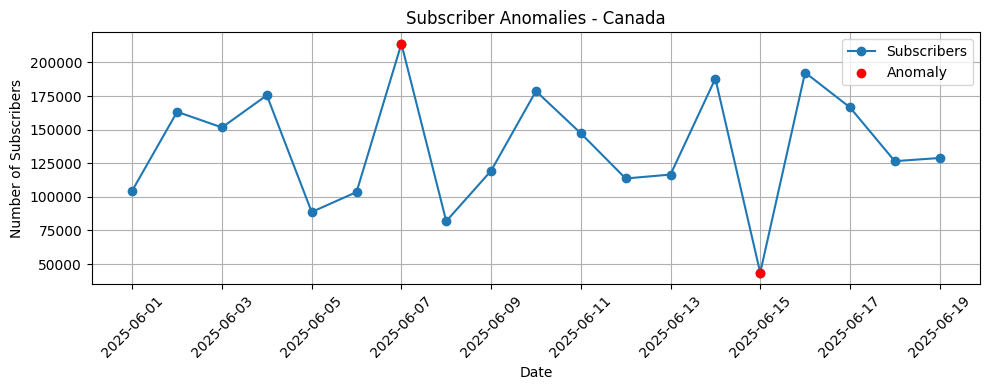

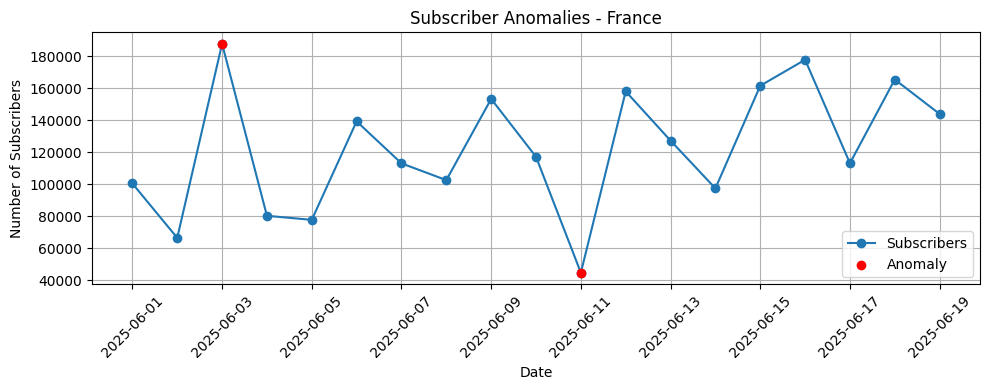

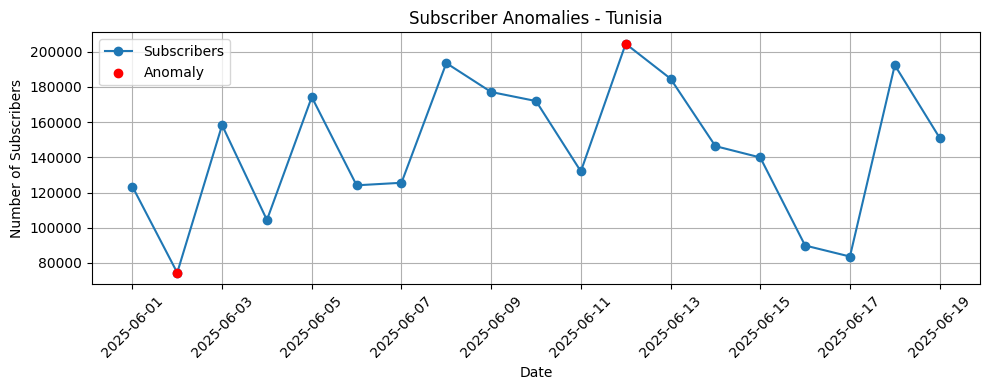

In [20]:
import pandas as pd
import random
from datetime import datetime
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# --- 1. Generate synthetic data ---
def generate_telecom_data(
    start_date="2025-06-01",
    end_date="2025-06-19",
    countries_ops=None,
    seed=42
):
    if countries_ops is None:
        countries_ops = {
            "Canada": ["Bell", "Rogers", "Telus"],
            "France": ["Orange", "SFR", "Bouygues"],
            "Tunisia": ["Ooredoo", "Orange TN", "Tunisie Telecom"]
        }

    random.seed(seed)
    date_range = pd.date_range(start=start_date, end=end_date)

    data = []
    for date in date_range:
        for country, operators in countries_ops.items():
            for operator in operators:
                subscribers = random.randint(1000, 90000)
                data.append({
                    "date": date.date(),
                    "country": country,
                    "operator": operator,
                    "number_of_subscribers": subscribers
                })

    return pd.DataFrame(data)

df = generate_telecom_data()

# --- 2. Aggregate by date and country ---
agg_df = df.groupby(['date', 'country'])['number_of_subscribers'].sum().reset_index()

# --- 3. Detect anomalies per country ---
def detect_anomalies_countrywise(data):
    results = []
    for country in data['country'].unique():
        subset = data[data['country'] == country].copy()
        model = IsolationForest(contamination=0.1, random_state=42)
        model.fit(subset[['number_of_subscribers']])
        subset['anomaly'] = model.predict(subset[['number_of_subscribers']])
        results.append(subset)
    return pd.concat(results)

anomaly_df = detect_anomalies_countrywise(agg_df)

# --- 4. Plot ---
for country in anomaly_df['country'].unique():
    sub = anomaly_df[anomaly_df['country'] == country]
    plt.figure(figsize=(10, 4))
    plt.plot(sub['date'], sub['number_of_subscribers'], label='Subscribers', marker='o')
    plt.scatter(
        sub[sub['anomaly'] == -1]['date'],
        sub[sub['anomaly'] == -1]['number_of_subscribers'],
        color='red', label='Anomaly', zorder=5
    )
    plt.title(f"Subscriber Anomalies - {country}")
    plt.xlabel("Date")
    plt.ylabel("Number of Subscribers")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

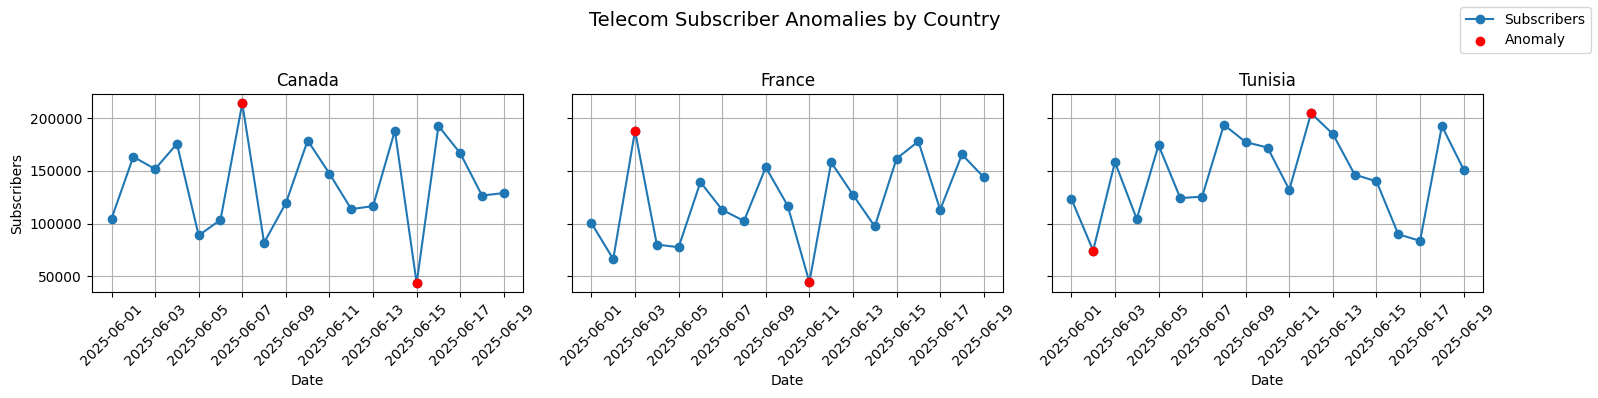

In [21]:
import matplotlib.pyplot as plt

# Prepare unique countries
countries = anomaly_df['country'].unique()
num_countries = len(countries)

# Create subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, num_countries, figsize=(16, 4), sharey=True)

# Loop through each country and corresponding axis
for i, country in enumerate(countries):
    ax = axes[i]
    sub = anomaly_df[anomaly_df['country'] == country]
    
    ax.plot(sub['date'], sub['number_of_subscribers'], label='Subscribers', marker='o')
    ax.scatter(
        sub[sub['anomaly'] == -1]['date'],
        sub[sub['anomaly'] == -1]['number_of_subscribers'],
        color='red', label='Anomaly', zorder=5
    )
    ax.set_title(f"{country}")
    ax.set_xlabel("Date")
    ax.tick_params(axis='x', rotation=45)
    if i == 0:
        ax.set_ylabel("Subscribers")
    ax.grid(True)

# Global legend and layout
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
fig.suptitle("Telecom Subscriber Anomalies by Country", fontsize=14)
plt.tight_layout(rect=[0, 0, 0.95, 0.95])
plt.show()


In [24]:
import requests

def fetch_carrier_prefixes(country_code='216'):
    # Raw URL for country code 33 (France)
    url = f"https://raw.githubusercontent.com/google/libphonenumber/master/resources/carrier/en/{country_code}.txt"
    
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Failed to fetch data for country code {country_code}")

    lines = response.text.strip().splitlines()

    # Parse lines (each line: prefix|carrier)
    data = []
    for line in lines:
        if '|' in line:
            prefix, carrier = line.split('|', 1)
            data.append({
                'prefix': prefix.strip(),
                'carrier': carrier.strip()
            })

    return data

# Example: Get France (country code 33) carrier data
carrier_data = fetch_carrier_prefixes('216')

# Print first 10
for entry in carrier_data[:10]:
    print(entry)


{'prefix': '2162', 'carrier': 'Ooredoo'}
{'prefix': '2164', 'carrier': 'Tunisie Telecom'}
{'prefix': '21645', 'carrier': 'Watany Ettisalat'}
{'prefix': '21646', 'carrier': 'Ooredoo'}
{'prefix': '21648', 'carrier': 'Ooredoo'}
{'prefix': '2165', 'carrier': 'Orange'}
{'prefix': '2169', 'carrier': 'Tunisie Telecom'}
